In [1]:
import pandas as pd
data= pd.read_csv(
    "loan_applic.csv"
    )

threshold = data['quality'].max()/2+1  # Define your threshold

data['quality'] = (data['quality'] > threshold).astype(int)
data['type'] = data['type'].apply(lambda x: 0 if x=='white' else 1)
counts = data['quality'].value_counts()
target_count = min(counts)
balanced_data = pd.concat([
    data[data['quality'] == 0].sample(target_count, replace=True),
    data[data['quality'] == 1].sample(target_count, replace=True)
])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
balanced_data['quality'].value_counts()
#data = balanced_data
features = data.copy()
features.fillna(0, inplace=True)
labels = features.pop('quality')
import numpy as np
features = np.array(features)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(features,labels):
    X_train, X_test = features[train_index],features[test_index]
    y_train, y_test = labels[train_index],labels[test_index]

KeyError: 'quality'

In [2]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
import warnings
warnings.filterwarnings("ignore")
clf.fit(X_train, y_train).score(X_test, y_test)

0.8138461538461539

In [3]:
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)

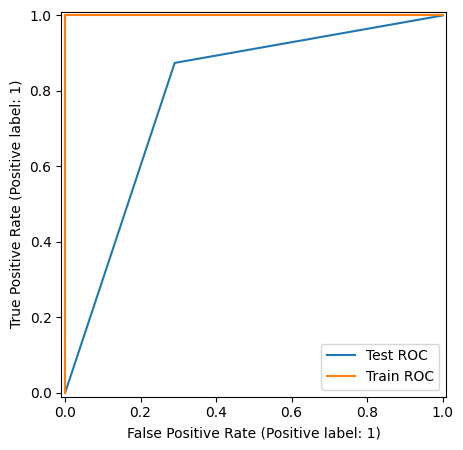

In [4]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')

In [5]:
import sklearn
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[ 508,  208],
       [ 155, 1079]])

In [6]:
sklearn.metrics.f1_score(y_test,predictions,average=None)

array([0.73676577, 0.85600952])

In [7]:
sklearn.metrics.roc_curve(y_test,predictions)

(array([0.        , 0.29050279, 1.        ]),
 array([0.        , 0.87439222, 1.        ]),
 array([inf,  1.,  0.]))

In [4]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
#    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators
)
import warnings
warnings.filterwarnings("ignore")
clf.fit(X_train, y_train).score(X_test, y_test)

0.8056410256410257

conf
[[ 498  218]
 [ 161 1073]]
f1
[0.72436364 0.84990099]
roc
(array([0.        , 0.30446927, 1.        ]), array([0.        , 0.86952998, 1.        ]), array([inf,  1.,  0.]))


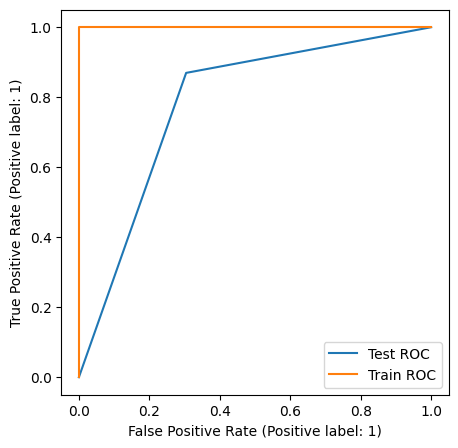

In [6]:
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
conf
[[ 505  211]
 [ 155 1079]]
f1
[0.73401163 0.85499208]
roc
(array([0.        , 0.29469274, 1.        ]), array([0.        , 0.87439222, 1.        ]), array([inf,  1.,  0.]))


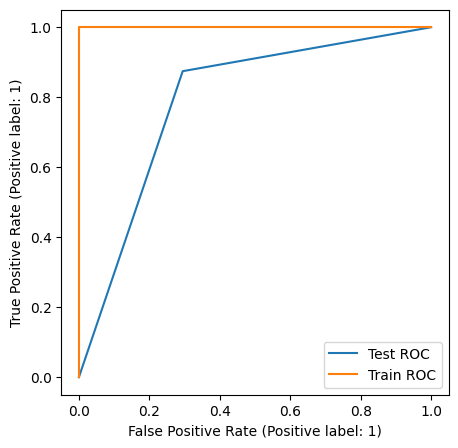

In [7]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
#    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
clf.fit(X_train, y_train).score(X_test, y_test)
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

In [10]:
clf.score(X_test, y_test)

0.8123076923076923

acc
0.8097435897435897
conf
[[ 507  209]
 [ 162 1072]]
f1
[0.73212996 0.85248509]
roc
(array([0.        , 0.29189944, 1.        ]), array([0.        , 0.86871961, 1.        ]), array([inf,  1.,  0.]))


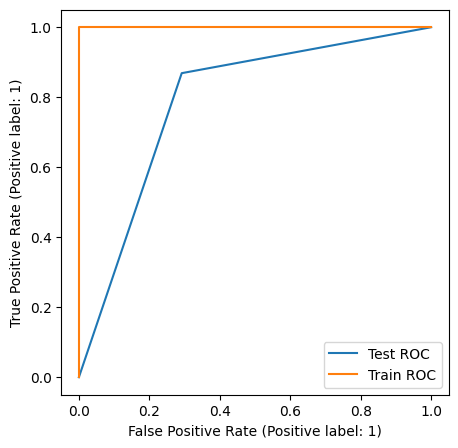

In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
#    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7805128205128206
conf
[[ 487  229]
 [ 199 1035]]
f1
[0.69472183 0.82866293]
roc
(array([0.       , 0.3198324, 1.       ]), array([0.        , 0.83873582, 1.        ]), array([inf,  1.,  0.]))


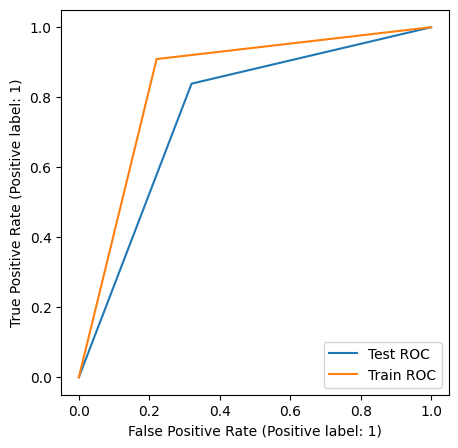

In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
#    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.8076923076923077
conf
[[ 502  214]
 [ 161 1073]]
f1
[0.72806381 0.8512495 ]
roc
(array([0.        , 0.29888268, 1.        ]), array([0.        , 0.86952998, 1.        ]), array([inf,  1.,  0.]))


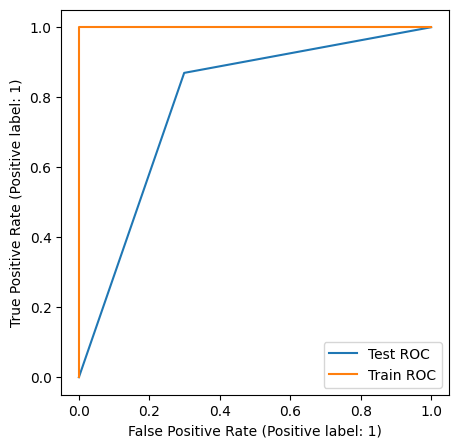

In [14]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
#    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.8112820512820513
conf
[[ 504  212]
 [ 156 1078]]
f1
[0.73255814 0.85419968]
roc
(array([0.        , 0.29608939, 1.        ]), array([0.        , 0.87358185, 1.        ]), array([inf,  1.,  0.]))


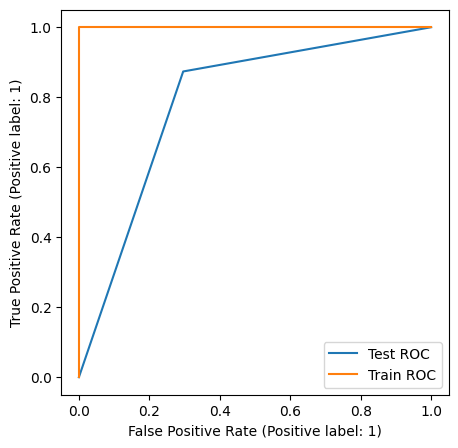

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
#    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7841025641025641
conf
[[ 474  242]
 [ 179 1055]]
f1
[0.69247626 0.83366258]
roc
(array([0.        , 0.33798883, 1.        ]), array([0.        , 0.85494327, 1.        ]), array([inf,  1.,  0.]))


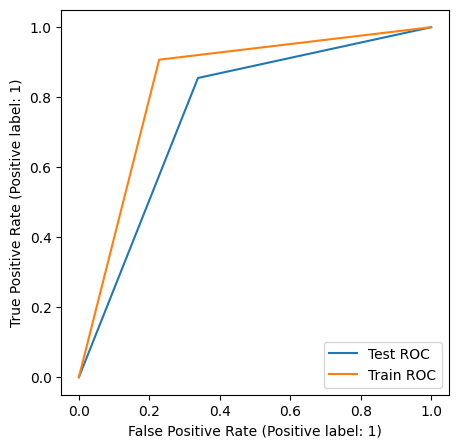

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
#    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier()
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.6758974358974359
conf
[[383 333]
 [299 935]]
f1
[0.54792561 0.74740208]
roc
(array([0.       , 0.4650838, 1.       ]), array([0.        , 0.75769854, 1.        ]), array([inf,  1.,  0.]))


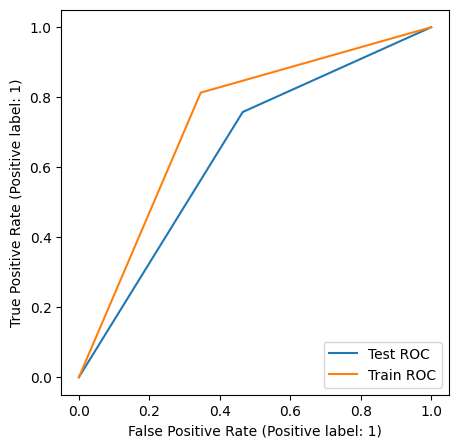

In [17]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
#    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier()
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7451282051282051
conf
[[ 439  277]
 [ 220 1014]]
f1
[0.63854545 0.80316832]
roc
(array([0.        , 0.38687151, 1.        ]), array([0.        , 0.82171799, 1.        ]), array([inf,  1.,  0.]))


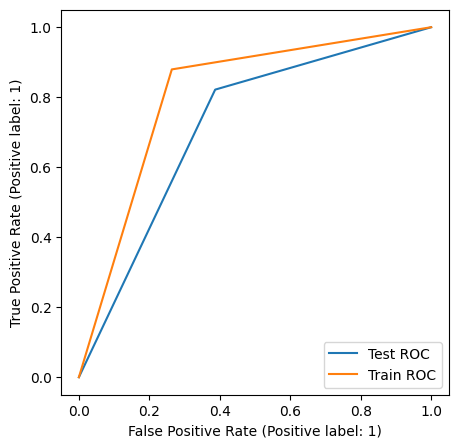

In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
#    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=KNeighborsClassifier()
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.778974358974359
conf
[[ 477  239]
 [ 192 1042]]
f1
[0.68880866 0.82862823]
roc
(array([0.        , 0.33379888, 1.        ]), array([0.        , 0.84440843, 1.        ]), array([inf,  1.,  0.]))


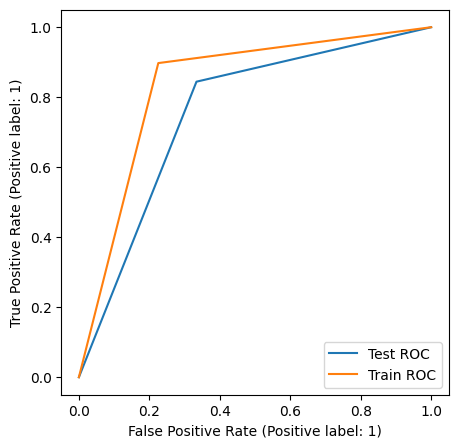

In [19]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
#    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=SVC()
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7743589743589744
conf
[[516 200]
 [240 994]]
f1
[0.70108696 0.81878089]
roc
(array([0.        , 0.27932961, 1.        ]), array([0.        , 0.80551053, 1.        ]), array([inf,  1.,  0.]))


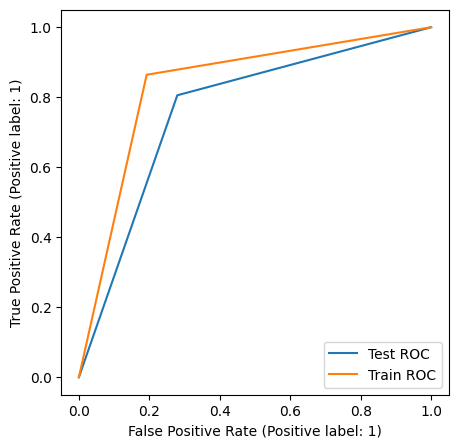

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
#    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=GaussianNB()
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7794871794871795
conf
[[ 468  248]
 [ 182 1052]]
f1
[0.6852123  0.83030781]
roc
(array([0.        , 0.34636872, 1.        ]), array([0.        , 0.85251216, 1.        ]), array([inf,  1.,  0.]))


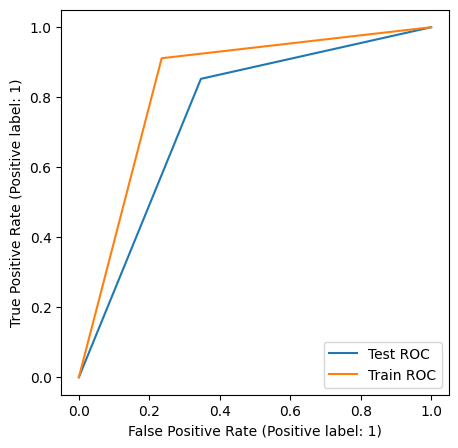

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
#    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=9,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)
import warnings
warnings.filterwarnings("ignore")
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.8241025641025641
conf
[[ 515  201]
 [ 142 1092]]
f1
[0.75018208 0.86426593]
roc
(array([0.        , 0.28072626, 1.        ]), array([0.        , 0.88492707, 1.        ]), array([inf,  1.,  0.]))


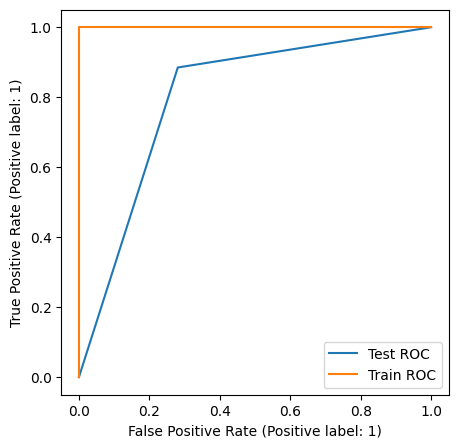

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters={'criterion':('gini','entropy','log_loss'),
            'bootstrap':(True,False),
            'oob_score':(True,False),
           
           }
import warnings
warnings.filterwarnings("ignore")
clf = GridSearchCV(RandomForestClassifier(), parameters)
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7830769230769231
conf
[[ 472  244]
 [ 179 1055]]
f1
[0.69056328 0.83300434]
roc
(array([0.        , 0.34078212, 1.        ]), array([0.        , 0.85494327, 1.        ]), array([inf,  1.,  0.]))


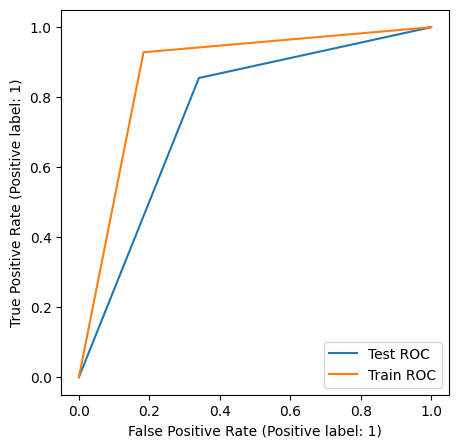

In [24]:
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings("ignore")
clf = BaggingClassifier(n_estimators=10, random_state=0, estimator=MLPClassifier(activation='relu',learning_rate='constant',alpha=0,hidden_layer_sizes=(50, 50)))
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7794871794871795
conf
[[ 492  224]
 [ 206 1028]]
f1
[0.69589816 0.82703138]
roc
(array([0.        , 0.31284916, 1.        ]), array([0.        , 0.83306321, 1.        ]), array([inf,  1.,  0.]))


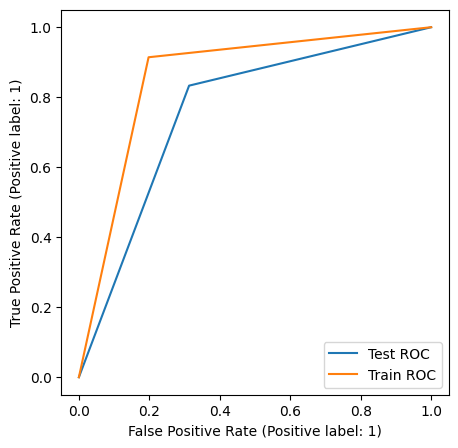

In [25]:
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings("ignore")
clf = BaggingClassifier(n_estimators=10, random_state=0, estimator=DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2))
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7912820512820513
conf
[[ 465  251]
 [ 156 1078]]
f1
[0.69558714 0.84120172]
roc
(array([0.        , 0.35055866, 1.        ]), array([0.        , 0.87358185, 1.        ]), array([inf,  1.,  0.]))


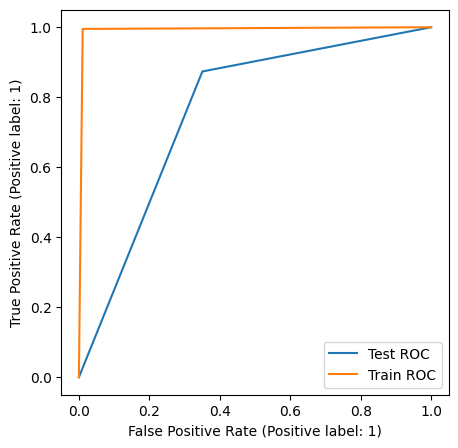

In [26]:
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings("ignore")
clf = BaggingClassifier(n_estimators=10, random_state=0, estimator=KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance'))
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7692307692307693
conf
[[ 473  243]
 [ 207 1027]]
f1
[0.67765043 0.82028754]
roc
(array([0.        , 0.33938547, 1.        ]), array([0.        , 0.83225284, 1.        ]), array([inf,  1.,  0.]))


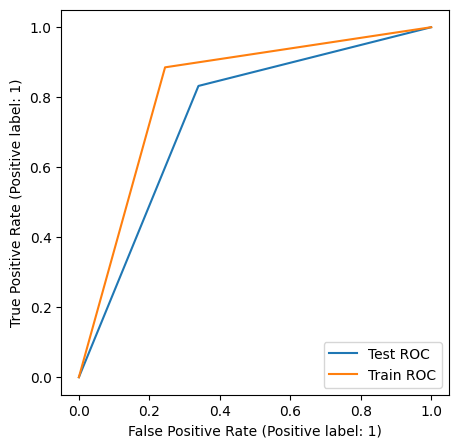

In [27]:
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings("ignore")
clf = BaggingClassifier(n_estimators=10, random_state=0, estimator=SVC(C=9,kernel='rbf'))
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.6774358974358974
conf
[[386 330]
 [299 935]]
f1
[0.55103498 0.74829932]
roc
(array([0.        , 0.46089385, 1.        ]), array([0.        , 0.75769854, 1.        ]), array([inf,  1.,  0.]))


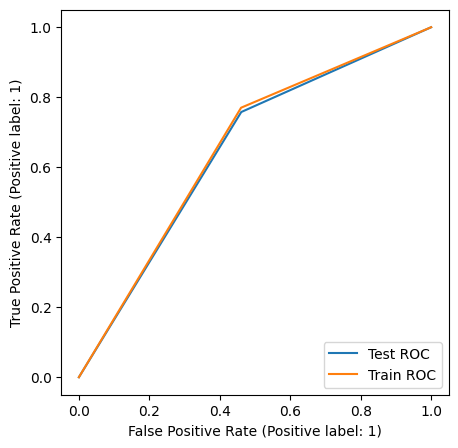

In [28]:
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings("ignore")
clf = BaggingClassifier(n_estimators=10, random_state=0, estimator=GaussianNB())
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.7353846153846154
conf
[[ 420  296]
 [ 220 1014]]
f1
[0.61946903 0.79716981]
roc
(array([0.        , 0.41340782, 1.        ]), array([0.        , 0.82171799, 1.        ]), array([inf,  1.,  0.]))


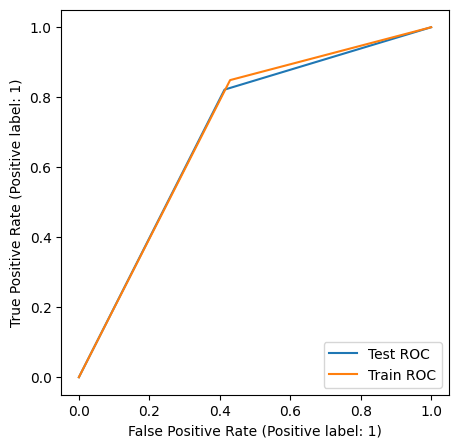

In [29]:
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings("ignore")
clf = BaggingClassifier(n_estimators=10, random_state=0, estimator=LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0))
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

acc
0.8271794871794872
conf
[[ 515  201]
 [ 136 1098]]
f1
[0.75347476 0.86695618]
roc
(array([0.        , 0.28072626, 1.        ]), array([0.       , 0.8897893, 1.       ]), array([inf,  1.,  0.]))


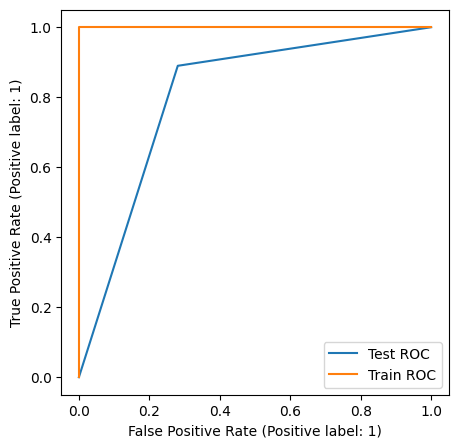

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
parameters={'criterion':('gini','entropy','log_loss'),
            'bootstrap':(True,False),
            'oob_score':(True,False)}
import warnings
warnings.filterwarnings("ignore")
clf = GridSearchCV(ExtraTreesClassifier(), parameters)
print('acc')
print(clf.fit(X_train, y_train).score(X_test, y_test))
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

In [8]:
from sklearn.tree import DecisionTreeClassifier
parameters = {
    'max_depth':(2,3,4,5,6,7,8,9,10),
    'min_samples_split':(2,3,4,5,6,7,8,9,10),
    'min_samples_leaf':(1,2,3,4,5,6,7,8,9,10),
    'ccp_alpha':(0,0.1,0.15,0.2),
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(DecisionTreeClassifier(), parameters)
import warnings
warnings.filterwarnings("ignore")
clf.fit(X_train, y_train)
clf.best_params_

{'ccp_alpha': 0, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3}

In [9]:
import sklearn

import optuna

# 1. Define an objective function to be maximized.
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 10)
    logmodel = DecisionTreeClassifier(max_depth=max_depth)
    logmodel.fit(X_train, y_train)
    predictions = logmodel.predict(X_test)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test, predictions)

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-03-11 18:22:38,641] A new study created in memory with name: no-name-cd8cc868-0cc8-463b-95cd-d825a7401717
[I 2024-03-11 18:22:38,667] Trial 0 finished with value: 0.7435897435897436 and parameters: {'max_depth': 10}. Best is trial 0 with value: 0.7435897435897436.
[I 2024-03-11 18:22:38,687] Trial 1 finished with value: 0.7476923076923077 and parameters: {'max_depth': 8}. Best is trial 1 with value: 0.7476923076923077.
[I 2024-03-11 18:22:38,696] Trial 2 finished with value: 0.7282051282051282 and parameters: {'max_depth': 3}. Best is trial 1 with value: 0.7476923076923077.
[I 2024-03-11 18:22:38,710] Trial 3 finished with value: 0.7338461538461538 and parameters: {'max_depth': 5}. Best is trial 1 with value: 0.7476923076923077.
[I 2024-03-11 18:22:38,732] Trial 4 finished with value: 0.7461538461538462 and parameters: {'max_depth': 8}. Best is trial 1 with value: 0.7476923076923077.
[I 2024-03-11 18:22:38,759] Trial 5 finished with value: 0.7512820512820513 and parameters: {'m

In [10]:
study.best_params

{'max_depth': 9}

conf
[[444 272]
 [242 992]]
f1
[0.63338088 0.79423539]
roc
(array([0.        , 0.37988827, 1.        ]), array([0.        , 0.80388979, 1.        ]), array([inf,  1.,  0.]))


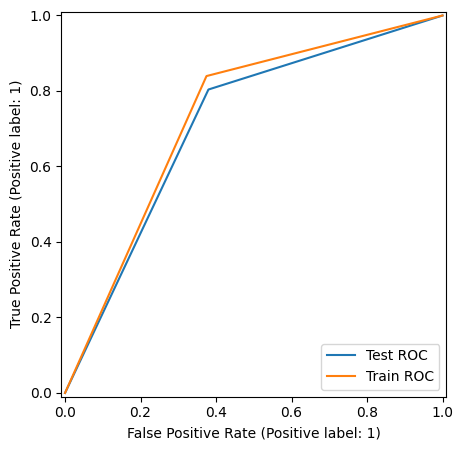

In [2]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
clf.score(X_test,predictions)
predictions_train = clf.predict(X_train)
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')
import sklearn
print('conf')
print(sklearn.metrics.confusion_matrix(y_test,predictions))
print('f1')
print(sklearn.metrics.f1_score(y_test,predictions,average=None))
print('roc')
print(sklearn.metrics.roc_curve(y_test,predictions))

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7507692307692307

In [28]:
import xgboost as xgb
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8066666666666666


In [33]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)


Accuracy: 0.7953846153846154


In [36]:
# Importing necessary libraries
import numpy as np
from catboost import CatBoostClassifier, Pool

# Creating a CatBoost Pool object for training data
train_pool = Pool(data=X_train, label=y_train)

# Initializing and training the CatBoost classifier
catboost_model = CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, loss_function='Logloss')
catboost_model.fit(train_pool)

# Making predictions on the test data
predictions = catboost_model.predict(X_test)

print("Predictions:", predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


0:	learn: 0.6685406	total: 722us	remaining: 71.5ms
1:	learn: 0.6494989	total: 2.17ms	remaining: 106ms
2:	learn: 0.6325505	total: 2.66ms	remaining: 85.9ms
3:	learn: 0.6181852	total: 3.3ms	remaining: 79.2ms
4:	learn: 0.6071340	total: 3.93ms	remaining: 74.7ms
5:	learn: 0.5951703	total: 4.58ms	remaining: 71.8ms
6:	learn: 0.5849904	total: 5.12ms	remaining: 68ms
7:	learn: 0.5777162	total: 5.68ms	remaining: 65.3ms
8:	learn: 0.5701147	total: 6.23ms	remaining: 63ms
9:	learn: 0.5638511	total: 6.85ms	remaining: 61.6ms
10:	learn: 0.5585862	total: 7.59ms	remaining: 61.4ms
11:	learn: 0.5531501	total: 8.12ms	remaining: 59.5ms
12:	learn: 0.5494341	total: 9.09ms	remaining: 60.9ms
13:	learn: 0.5446819	total: 9.73ms	remaining: 59.8ms
14:	learn: 0.5402005	total: 10.6ms	remaining: 60.2ms
15:	learn: 0.5360461	total: 11.2ms	remaining: 58.6ms
16:	learn: 0.5332190	total: 11.7ms	remaining: 57ms
17:	learn: 0.5297625	total: 12.2ms	remaining: 55.4ms
18:	learn: 0.5278430	total: 12.6ms	remaining: 53.8ms
19:	learn: 0